# Data load (Works for both greyscale and colored images)

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
tf.keras.backend.clear_session()


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
#Function to load both greyscale and colored images. Converts them to RGB (for greyscale: R = G = B)

def load_images_from_folder(folder, label, max_images, image_size):
    images = []
    labels = []
    for i, filename in enumerate(os.listdir(folder)):
        if filename.endswith(".jpg"):
            if i >= max_images:
                break
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)

            if img is None:
                continue  # Skip unreadable files

            if len(img.shape) == 2:  # If data is grayscale image
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img = cv2.resize(img, (image_size, image_size))
            img = img / 255.0
            images.append(img)
            labels.append(label)
    return images, labels

In [4]:
#CHANGE THINGS HERE!!


NORMAL_PATH = "../archive/Multi Cancer/Multi Cancer/Breast Cancer/breast_benign"
TUMOR_PATH = "../archive/Multi Cancer/Multi Cancer/Breast Cancer/breast_malignant"

print("'Normal' images:", os.listdir(NORMAL_PATH)[:5])
print("'Tumor' images:", os.listdir(TUMOR_PATH)[:5])

image_size = 224
max_images = 5000

'Normal' images: ['breast_benign_1863.jpg', 'breast_benign_3912.jpg', 'breast_benign_3906.jpg', 'breast_benign_1877.jpg', 'breast_benign_4927.jpg']
'Tumor' images: ['breast_malignant_0505.jpg', 'breast_malignant_4763.jpg', 'breast_malignant_2312.jpg', 'breast_malignant_2474.jpg', 'breast_malignant_4005.jpg']


In [5]:
#Load in the data

normal_images, normal_labels = load_images_from_folder(NORMAL_PATH, 0, max_images = max_images, image_size = image_size)
tumor_images, tumor_labels = load_images_from_folder(TUMOR_PATH, 1, max_images = max_images, image_size = image_size)

#Combine
X = np.array(normal_images + tumor_images)
y = np.array(normal_labels + tumor_labels)


print(f"Total samples read: {len(X)} (Normal: {len(normal_images)}, Tumor: {len(tumor_images)})")

Total samples read: 10000 (Normal: 5000, Tumor: 5000)


# Training summary

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

In [7]:
def plot_training_summary(history, model, X_val, y_val, fig_name, training_time=None, best_epoch=None, save_fig=False):
    # Predict probabilities and labels
    y_probs = model.predict(X_val).ravel()
    y_pred = (y_probs > 0.5).astype(int)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_probs)
    roc_auc = auc(fpr, tpr)

    # Create 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # --- Accuracy Plot ---
    axs[0, 0].plot(history.history['accuracy'], label='Train Acc')
    axs[0, 0].plot(history.history['val_accuracy'], label='Val Acc')
    axs[0, 0].set_title('Accuracy over Epochs')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # --- Loss Plot ---
    axs[0, 1].plot(history.history['loss'], label='Train Loss')
    axs[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axs[0, 1].set_title('Loss over Epochs')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[1, 0], colorbar=False)
    axs[1, 0].set_title('Confusion Matrix')

    # --- ROC Curve ---
    axs[1, 1].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    axs[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[1, 1].set_title('ROC Curve')
    axs[1, 1].set_xlabel('False Positive Rate')
    axs[1, 1].set_ylabel('True Positive Rate')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # Add training time and best epoch as text
    if training_time is not None and best_epoch is not None:
        summary_text = f"Training time: {training_time:.2f} seconds\nBest epoch: {best_epoch}"
        fig.text(0.5, 0.01, summary_text, ha='center', fontsize=12)

        print("Training Summary:")
        print(summary_text)

    if save_fig:
        plt.savefig('script_results/Model_summary_' + fig_name + '.png')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


# Initial CNN

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time
from tensorflow.keras.layers import Input

In [9]:
# Defining a basic CNN model

def initial_cnn(input_shape, dropout_rate, learning_rate, X_train, y_train, X_val, y_val):
    model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Binary classification
])

    
    model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')])

    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    start_time = time.time()

    history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping])

    end_time = time.time()

    training_time = end_time-start_time

    best_epoch = np.argmin(history.history['val_loss']) + 1 

    return model, history, training_time, best_epoch

In [10]:
# Split into train:val:test -> 70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42, stratify = y_temp)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 7000, Validation size: 1500, Test size: 1500


In [ ]:

dropout_rate = 0.5
learning_rate = 0.001

initial_model, initial_history, initial_model_time, initial_model_epochs = initial_cnn(X_train[0].shape, dropout_rate = dropout_rate, learning_rate = learning_rate, X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val)


In [ ]:
#Plot and save train summary. The trained model is also saved.

model_name = 'initial_cnn_breast' #CHANGE NAME

plot_training_summary(initial_history, initial_model, X_val, y_val, fig_name=model_name, training_time=initial_model_time, best_epoch=initial_model_epochs, save_fig = True)
initial_model.save('script_results/'+model_name+'.keras')

# Auto encoder

In [8]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

In [9]:
def build_autoencoder(input_shape=(224, 224, 3)):
    input_img = Input(shape=input_shape)

    # --- Encoder ---
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)     # 224x224x32
    x = MaxPooling2D((2, 2), padding='same')(x)                              # 112x112x32
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)             # 112x112x16
    encoded = MaxPooling2D((2, 2), padding='same')(x)                        # 56x56x16

    # --- Decoder (attached to autoencoder model only) ---
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)                                              # 112x112x16
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                                              # 224x224x32
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)     # 224x224x3

    # --- Models ---
    autoencoder = Model(input_img, decoded, name='autoencoder')
    encoder = Model(input_img, encoded, name='encoder')

    # --- Standalone decoder model ---
    encoded_input = Input(shape=(56, 56, 16))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoder_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    decoder = Model(encoded_input, decoder_output, name="decoder")

    autoencoder.compile(optimizer=Adam(1e-3), loss='mse')

    return autoencoder, encoder, decoder



def train_autoencoder(X, y, input_shape=(224, 224, 3)):
    # Sample part of data for unsupervised training
    train_fraction = 0.2
    n_auto = int(len(X) * train_fraction)
    X_auto_train, _, y_auto_train, _ = train_test_split(X, y, train_size=n_auto, stratify=y, random_state=42)

    # Build model
    autoencoder, encoder, decoder = build_autoencoder(input_shape=input_shape)

    # Training
    start = time.time()
    autoencoder.fit(X_auto_train, X_auto_train,
                              epochs=15,
                              batch_size=16,
                              validation_split=0.1,
                              shuffle=True,
                              verbose=1)
    end = time.time()
    elapsed = end - start

    print(f"\nAutoencoder training completed in {elapsed:.2f} seconds.")

    return autoencoder, encoder, decoder, elapsed

In [10]:
auto_encoder, encoder, decoder, train_time = train_autoencoder(X = X, y = y, input_shape = (224, 224, 3))

#CHANGE HERE

cancer_type = 'breast'

#Save the trained autoencoder for later use

auto_encoder.save('script_results/'+cancer_type + "autoencoder_model.keras")
encoder.save('script_results/'+cancer_type + "encoder_model.keras")
decoder.save('script_results/'+cancer_type + "decoder_model.keras")

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 228ms/step - loss: 0.0286 - val_loss: 0.0114
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step - loss: 0.0106 - val_loss: 0.0069
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 225ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 9/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 10/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 11/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 12/15
113/113

FileNotFoundError: [Errno 2] No such file or directory: 'script_results/breastautoencoder_model.keras'

In [11]:
auto_encoder.save('script_results/'+cancer_type + "autoencoder_model.keras")
encoder.save('script_results/'+cancer_type + "encoder_model.keras")
decoder.save('script_results/'+cancer_type + "decoder_model.keras")

In [12]:
#Encoding all images using the trained encoder

X_encoded = encoder.predict(X)

print(f"Compressed image shape: {X_encoded.shape}")

#Save encoded X and corresponding y so you don't have to retrain

np.save('script_results/'+cancer_type +"X_encoded_224.npy", X_encoded)
np.save('script_results/'+cancer_type + "y_for_encoded_224.npy", y)

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step
Compressed image shape: (10000, 56, 56, 16)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


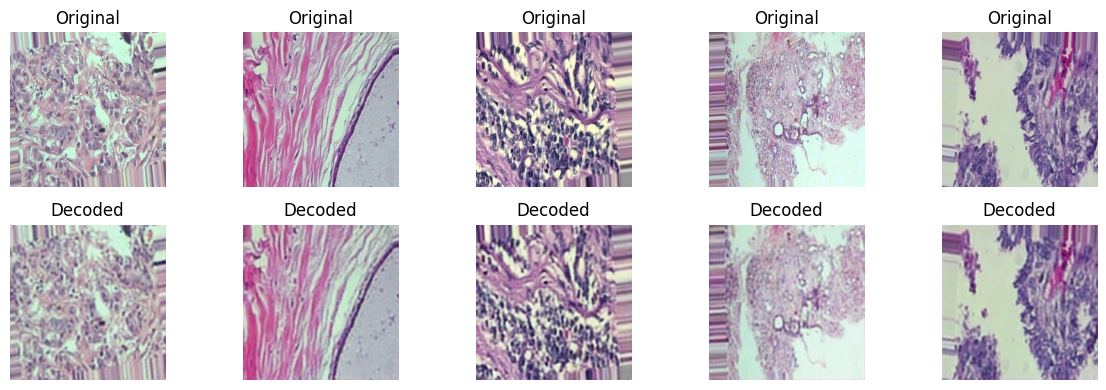

In [ ]:
import matplotlib.pyplot as plt

# Encode and decode some images
decoded_imgs = auto_encoder.predict(X[0:10])

# Number of images to display
n = 5

plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Decoded")
    plt.axis("off")

plt.savefig('script_results/'+cancer_type + 'autoencoded_images.png')

plt.tight_layout()
plt.show()

# Initial CNN on auto-encoded images

In [14]:
# Split into train:val:test -> 70:15:15
X_train_enc, X_temp_enc, y_train_enc, y_temp_enc = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)
X_val_enc, X_test_enc, y_val_enc, y_test_enc = train_test_split(X_temp_enc, y_temp_enc, test_size = 0.5, random_state = 42, stratify = y_temp_enc)

print(f"Train size: {len(X_train_enc)}, Validation size: {len(X_val_enc)}, Test size: {len(X_test_enc)}")

Train size: 7000, Validation size: 1500, Test size: 1500


In [18]:

dropout_rate = 0.5
learning_rate = 0.001

auto_model, auto_history, auto_model_time, auto_model_epochs = initial_cnn(X_train_enc[0].shape, dropout_rate = dropout_rate, learning_rate = learning_rate, X_train = X_train_enc, y_train = y_train_enc, X_val = X_val_enc, y_val = y_val_enc)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7252 - auc: 0.8049 - loss: 0.5114 - val_accuracy: 0.8147 - val_auc: 0.9341 - val_loss: 0.4498
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8454 - auc: 0.9180 - loss: 0.3678 - val_accuracy: 0.8727 - val_auc: 0.9526 - val_loss: 0.2943
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8834 - auc: 0.9475 - loss: 0.2922 - val_accuracy: 0.8900 - val_auc: 0.9653 - val_loss: 0.2614
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8792 - auc: 0.9481 - loss: 0.2926 - val_accuracy: 0.9060 - val_auc: 0.9701 - val_loss: 0.2251
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9007 - auc: 0.9665 - loss: 0.2363 - val_accuracy: 0.9000 - val_auc: 0.9705 - val_loss: 0.2410
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9070 - auc: 0.9710 - loss: 0.2187 - val_accuracy: 0.9220 - val_auc: 0.9818 - val_loss: 0.1966
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training Summary:
Training time: 141.06 seconds
Best epoch: 16


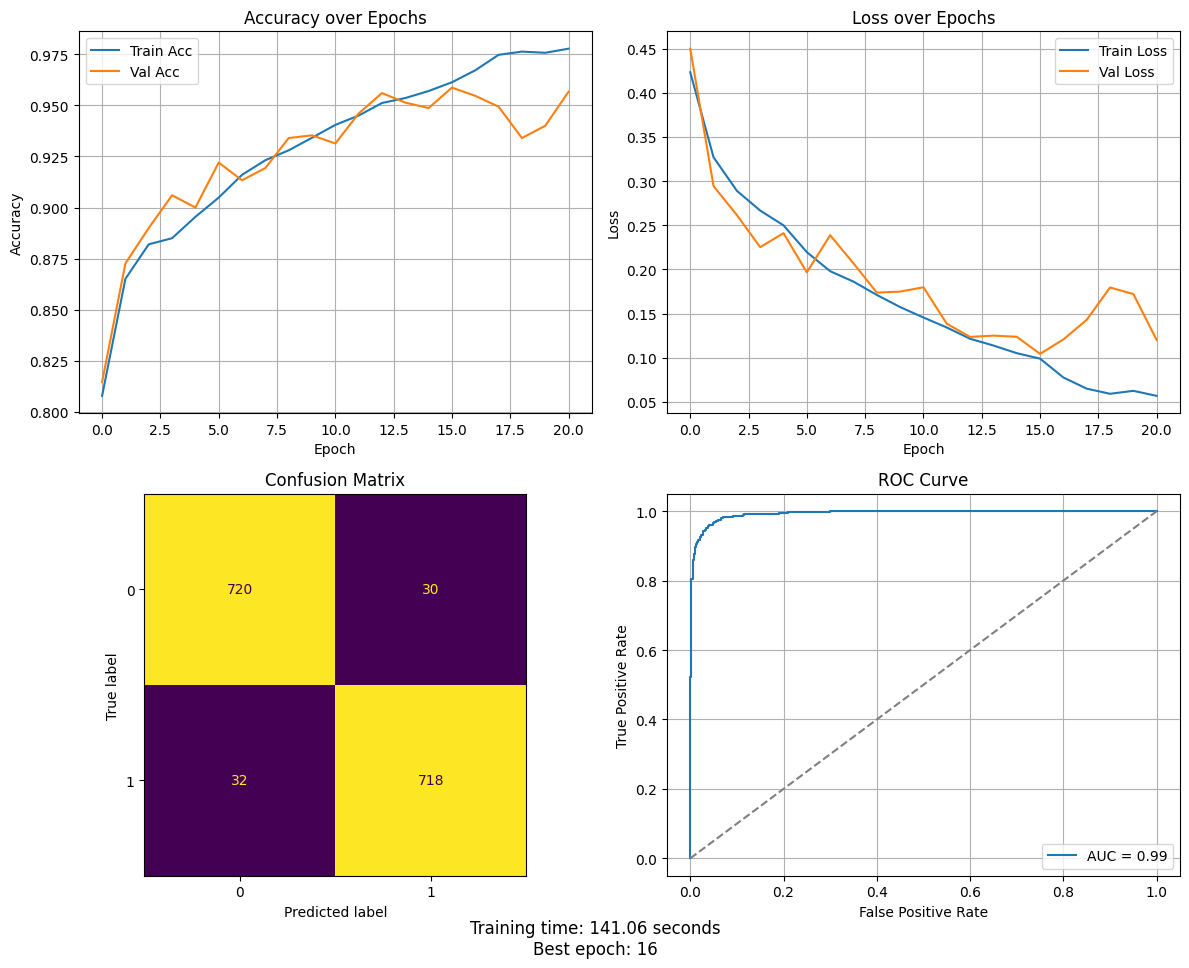

In [19]:
#Plot and save train summary. The trained model is also saved.

model_name = 'autoencoded_cnn_breast' #CHANGE NAME

plot_training_summary(auto_history, auto_model, X_val_enc, y_val_enc, fig_name=model_name, training_time=auto_model_time, best_epoch=auto_model_epochs, save_fig = True)
auto_model.save('script_results/'+model_name+'.keras')

In [13]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Grad-CAM Heatmap Function
def get_gradcam_heatmap(model, image, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of top predicted class w.r.t conv layer output
    grads = tape.gradient(class_channel, conv_outputs)

    # Global average pooling over height and width
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Multiply feature maps by their importance
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 2. Overlay Heatmap on Original Image
def overlay_heatmap(heatmap, original_img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = cv2.addWeighted(heatmap_colored, alpha, np.uint8(original_img * 255), 1 - alpha, 0)
    return superimposed_img

# 3. Visualize with Grad-CAM
def visualize_gradcam(model, image, last_conv_layer_name):
    heatmap = get_gradcam_heatmap(model, image, last_conv_layer_name)
    superimposed_img = overlay_heatmap(heatmap, image)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [12]:
from tensorflow.keras.models import load_model

model_name = 'autoencoded_cnn_breast'


model_path = 'script_results/' + model_name + '.keras'
model = load_model(model_path)
model.summary()  # Helpful for finding the last conv layer


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 54, 54, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,520,549 (5.80 MB)

 Trainable params: 506,849 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,013,700 (3.87 MB)

In [14]:
sample_image = X[0]  # Must be normalized (values in 0-1)
last_conv_layer = 'conv2d_10'  # Replace with actual name from model.summary()

visualize_gradcam(model, sample_image, last_conv_layer)


AttributeError: The layer sequential has never been called and thus has no defined output.

In [15]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('script_results/' + model_name + '.keras')

# Force model to build by calling it with a sample image
_ = model.predict(np.expand_dims(X[0], axis=0))


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_8" is incompatible with the layer: expected axis -1 of input shape to have value 16, but received input with shape (1, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Freeze layers to avoid accidental training
encoder.trainable = False
cnn_model.trainable = False

# Chain encoder + cnn
input_img = Input(shape=(224, 224, 3))
encoded = encoder(input_img)
output = cnn_model(encoded)

# Full model from raw image to classification
full_model = Model(inputs=input_img, outputs=output)


NameError: name 'encoder' is not defined

In [22]:
from tensorflow.keras.models import load_model

encoder = load_model('script_results/breastencoder_model.keras')
decoder = load_model('script_results/breastdecoder_model.keras')
classifier = load_model('script_results/autoencoded_cnn_breast.keras')  # or use model_name if dynamic


In [23]:
sample_image = X[0]  # shape: (224, 224, 3), normalized

encoded_image = encoder.predict(np.expand_dims(sample_image, axis=0))  # shape: (1, 56, 56, 16)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [24]:
def get_gradcam_heatmap(model, image, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [25]:
def overlay_heatmap_on_decoded(heatmap, encoded_input, decoder_model, alpha=0.5):
    decoded_img = decoder_model.predict(np.expand_dims(encoded_input, axis=0))[0]
    decoded_img = np.uint8(255 * decoded_img)

    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(heatmap_colored, alpha, decoded_img, 1 - alpha, 0)

    return superimposed


In [27]:
# Build the classifier by calling it once with encoded input
_ = classifier(np.expand_dims(encoded_image[0], axis=0))


In [28]:
# Build the classifier model by calling it
_ = classifier.predict(encoded_image)

# Use the actual name of the last Conv2D layer in classifier (check classifier.summary())
heatmap = get_gradcam_heatmap(classifier, encoded_image, last_conv_layer_name='conv2d_10')

# Decode and overlay
result = overlay_heatmap_on_decoded(heatmap, encoded_image[0], decoder)

# Show it
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grad-CAM on Autoencoded Image")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


AttributeError: The layer sequential has never been called and thus has no defined output.

In [30]:
model.summary

<bound method Model.summary of <Sequential name=sequential, built=True>>